**ТОВАРНЫЕ РЕКОМЕНДАЦИИ ДЛЯ E-COMM**

**Часть 2 - Процессинг**

**Датасет**:  Описывает лог покупок в интернет магазине за определенный период

**Цель**: На основании данных предоставить товарные рекомендации для последующей Email рассылки.

In [1]:
# импорт библиотек 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from datetime import date
from datetime import timedelta

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
# настройка размера графиков
plt.rcParams["figure.figsize"] = (12,6) # размер графиков для всего блокнота

In [3]:
plt.style.use('ggplot') # выбор стиля графиков по умолчанию

In [5]:
# форматирование дробных чисел

pd.options.display.float_format = '{:.3f}'.format

# Загрузка

In [7]:
df = pd.read_csv('ecommerce_dataset_preprocessed.csv') # данные из 1-ой части анализа
df.sample()

,date,customer_id,order_id,product,quantity,price,timestamp,cost,serial_number_order,is_regular_customer,first_word,category,is_opt_order
1263,2019-01-18 00:00:00,baafdc94-c232-455e-ba15-174a0e97ae34,14525,пеларгония зональная диам. 12 см сиреневый пол...,1,188.000,2019-01-18 19:00:00,188.000,1,0,пеларгония,пеларгония,0.000


Колонки в  *ecommerce_dataset_preprocessed.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара;
- `timestamp` - время заказа;
- `cost` - стоимость (price*quantity);
- `serial_number_order` - порядковый номер заказа для клиента;
- `is_regular_customer` - флаг является ли клиент постоянным;
- `is_opt_order` - является ли заказ мелкооптовым;

- `category` - категория товара, определенная, как первое существительное из названия товара или 'другое'.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4708 entries, 0 to 4707
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 4708 non-null   object 
 1   customer_id          4708 non-null   object 
 2   order_id             4708 non-null   int64  
 3   product              4708 non-null   object 
 4   quantity             4708 non-null   int64  
 5   price                4708 non-null   float64
 6   timestamp            4708 non-null   object 
 7   cost                 4708 non-null   float64
 8   serial_number_order  4708 non-null   int64  
 9   is_regular_customer  4708 non-null   int64  
 10  first_word           4708 non-null   object 
 11  category             4708 non-null   object 
 12  is_opt_order         4708 non-null   float64
dtypes: float64(3), int64(4), object(6)
memory usage: 478.3+ KB


In [9]:
for x in ['customer_id', 'order_id', 'product', 'category']:
    print(x+':', df[x].nunique())
    print('---')

customer_id: 2284
---
order_id: 2586
---
product: 2231
---
category: 233
---


In [10]:
print('Количество клиентов, которые сделали больше 2-х заказов:', end=' ')
print(df[df['is_regular_customer'] == 1]['customer_id'].nunique())

Количество клиентов, которые сделали больше 2-х заказов: 158


In [11]:
# максимальное количество заказов на каждого клиента в датасете

df.groupby('customer_id')['serial_number_order'].max().value_counts().sort_index()

1      2130
2       126
3        20
4         3
5         1
7         1
17        1
35        1
126       1
Name: serial_number_order, dtype: int64

In [12]:
print('Уникальное количество товаров в первых заказах:', df[df['serial_number_order'] == 1]['product'].nunique())
print('Уникальное количество товаров в последующих заказах:', df[df['serial_number_order'] > 1]['product'].nunique())

Уникальное количество товаров в первых заказах: 2071
Уникальное количество товаров в последующих заказах: 424


In [13]:
print('Уникальное количество категорий в первых заказах:', df[df['serial_number_order'] == 1]['category'].nunique())
print('Уникальное количество категорий в последующих заказах:', df[df['serial_number_order'] > 1]['category'].nunique())

Уникальное количество категорий в первых заказах: 230
Уникальное количество категорий в последующих заказах: 114


**Итог**

Для группировки товарных рекомендаций были выбраны категории товаров (`category`), поскольку товар (`product`) обладает слишком высокой разрядностью. 

Далее в комментариях и описании под товаром подразумевается категория товара (`category`).

# Config & Описание алгоритма

*Шаг 1*

**Задача:** Подсчитать с какой вероятностью будет куплен товар Y, если в первом заказе присутствовал товар Х

**Результат:** Матрица вероятности, где на пересечении товара Y c товаром Х указана вероятность заказа товара Y, если товар в первом заказе X


*Шаг 2*

**Задача:** Рассчитать скоринг для каждого товара Y

**Результат:** Предыдущая матрица, умноженная на медианную стоимость товара Y

*Шаг 3:*

**Задача:** Подготовить список рекомендаций для каждого клиента

**Результат:** Топ-N товаров c сортировкой по скорингу для каждого клиента в нужном формате

In [14]:
# отсечка для количества покупок, совершенных постоянным клиентом

max_orders_for_client = (df
                         .groupby('customer_id')['serial_number_order'].max()
                         .quantile(.999)) 

In [15]:
print('max_orders_for_client = {:.2f}'.format(max_orders_for_client))

max_orders_for_client = 14.17


In [32]:
max_orders_for_client # отсечка для количества покупок, совершенных постоянным клиентом
normalize = 'customer_id' # как нормализировать рекомендации
item = 'category' # что именно рекомендуем

# Формат письма подразумевает возможность указать от 2 до 6 товаров. 
# Это является нашим ограничением по количеству товарных рекомендаций.

min_n_rec_items = 2 # минимальное количество товаров для рекомендаций
max_n_rec_items = 6 # максимальное количество товаров для рекомендаций

# Матрица вероятности участия товара в следующем заказе

## Определяем товары, участвующие в первых заказах постоянных клиентов

In [17]:
# выберем все товары в первых заказах тех клиентов, которые делали больше одной покупки 

first_items = df[(df['serial_number_order'] == 1)&(df['is_regular_customer'] == 1)][[normalize, item]]
first_items.columns = [normalize, 'first_items']

In [18]:
first_items.head()

,customer_id,first_items
9,c971fb21-d54c-4134-938f-16b62ee86d3b,чехол
11,4d93d3f6-8b24-403b-a74b-f5173e40d7db,чехол
47,49b9c587-c19e-4481-bace-967aeac357fa,пеларгония
48,49b9c587-c19e-4481-bace-967aeac357fa,пеларгония
49,49b9c587-c19e-4481-bace-967aeac357fa,пеларгония


In [19]:
# количество уникальных товаров

n_first_items = first_items['first_items'].nunique()
n_first_items

77

In [20]:
# распределение по уникальным товарам в первых заказах

first_items.groupby('first_items')['first_items'].count().value_counts(normalize=True).sort_index().head()

1   0.597
2   0.143
3   0.039
4   0.039
5   0.026
Name: first_items, dtype: float64

**Комментарий**

Наблюдаем ~60% уникальных товаров, которые встречались лишь 1 раз среди первых заказов. Выводы на таком количестве данных будут носить недостоверный характер. 
Но, при их удалении количество уникальных товаров появится другая проблема - нехватка данных для рекомендаций.

Из-за размера датасета было принято решение оставить товары, которые встречались лишь 1 раз среди первых заказов

## Определяем товары, участвующие в последующих заказах постоянных клиентов

In [21]:
# создадим датасет с товарами для заказов, которые являются вторыми и следующими

next_items = df[(df['serial_number_order'].between(2, max_orders_for_client))][[normalize, item, 'serial_number_order']]

next_items.columns = [normalize, 'next_items', 'serial_number_order']

In [22]:
# количество уникальных товаров

n_next_items = next_items['next_items'].nunique()
n_next_items

91

In [23]:
# распределение частоты встречания по уникальным товарам в последующих заказах

next_items.groupby('next_items')['next_items'].count().value_counts(normalize=True).sort_index().head()

1   0.484
2   0.165
3   0.088
4   0.077
5   0.022
Name: next_items, dtype: float64

## Расчет матрицы вероятности последующего заказа товара

In [24]:
# объединим датасет с товарами для первых заказов и датасет с товарами для вторых и последующих заказов

products = first_items.merge(next_items, on=normalize)
products = products.iloc[:,1:-1]

In [25]:
# создадим пустой датасет с индексом на котором будем делать матрицresult_prob.columns = ['next_items']

result_prob = pd.DataFrame(products['next_items'].unique(), columns=['next_items']) 

for first_item in products['first_items'].unique(): # пройдемся по уникальным значениям товаров из первых заказов
    
    # сформируем вероятность для каждого первого товара
    
    prob_next_items = products[products['first_items'] == first_item]['next_items'].value_counts(normalize=True).reset_index() 
    prob_next_items.columns = ['next_items', first_item] 
    
    # присоединим к подготовленному датасету
    
    result_prob = result_prob.merge(prob_next_items, on='next_items', how='outer')  

result_prob = result_prob.set_index('next_items')
result_prob = result_prob.fillna(0)

In [26]:
# проверяем, что в получившейся таблице количество первых и последующих уникальных товаров соответствует начальным

result_prob.shape == (n_next_items, n_first_items)

False

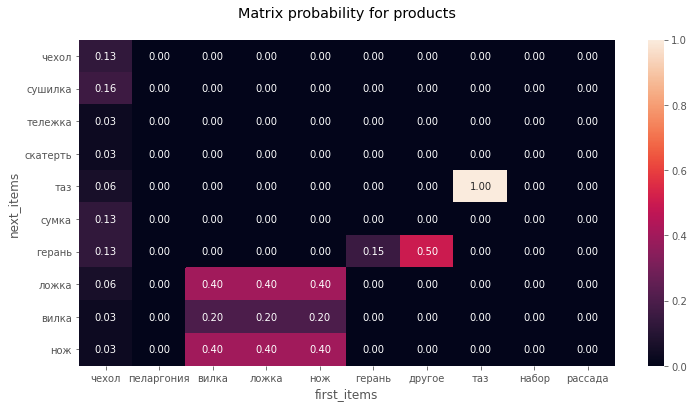

In [27]:
# вид матрицы для первых 10 столбцов и строк
sns.heatmap(result_prob.iloc[:10,:10], annot=True, fmt=".2f")
plt.title('Matrix probability for products'+ '\n')
plt.xlabel('first_items')
plt.show();

In [28]:
result_prob['чехол'].nlargest(max_n_rec_items*2).reset_index()

,next_items,чехол
0,сушилка,0.161
1,чехол,0.129
2,сумка,0.129
3,герань,0.129
4,таз,0.065
5,ложка,0.065
6,тележка,0.032
7,скатерть,0.032
8,вилка,0.032
9,нож,0.032


In [29]:
result_prob.to_csv('probability_matrix.csv')

# Расчет скоринга для сортировки товарных рекомендаций

Полученные рекомендации необходимо отсортировать и выбрать лучшие. Выбранные товарные рекомендации будут помещены в E-mail письмо, которое направляется клиенту. 

Для того чтобы увеличить эффективность товарных рекомендаций для бизнес - заказчика мы применим скоринг на основании математического ожидания выручки, рассчитанное как произведение медианной выручки товара и вероятности покупки данного товара в составе следующего заказа

In [33]:
items_price_median = df.groupby('category')['price'].median().reset_index()

In [34]:
result_scoring = result_prob.copy()
result_scoring = result_scoring.T


for column in result_scoring:
    cost = items_price_median[items_price_median[item] == column]['price'].sum()
    result_scoring[column] = result_scoring[column] * cost
    
result_scoring = result_scoring.T

In [35]:
result_scoring['чехол'].nlargest(round(max_n_rec_items*2)).reset_index()

,next_items,чехол
0,сумка,212.774
1,сушилка,105.161
2,чехол,38.581
3,скатерть,31.419
4,штора,31.419
5,простыня,29.613
6,чайник,24.161
7,тележка,23.677
8,контейнер,21.742
9,герань,19.226


Text(0.5, 1.0, 'Диаграмма скоринга для каждого товара\n')

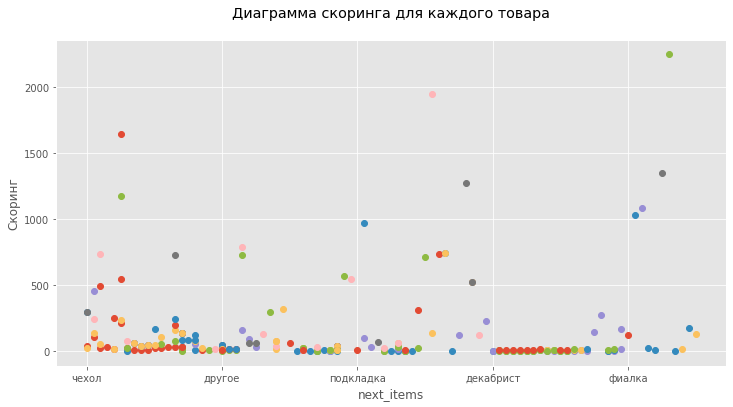

In [36]:
result_scoring[result_scoring>0].plot(style='o', legend=False)

plt.ylabel('Скоринг')
plt.title('Диаграмма скоринга для каждого товара'+'\n')

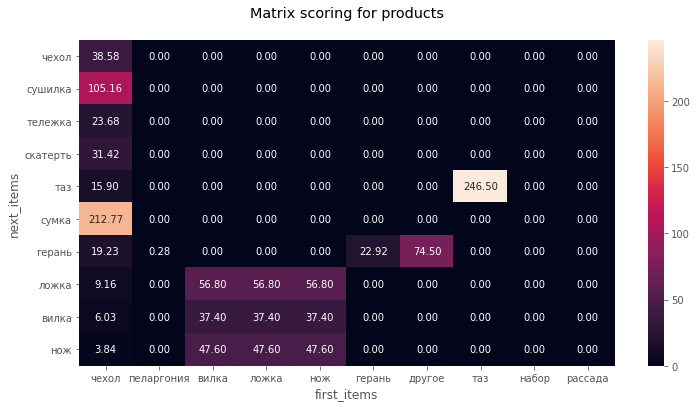

In [37]:
# вид матрицы для первых 10 столбцов и строк

sns.heatmap(result_scoring.iloc[:10,:10], annot=True, fmt=".2f")
plt.title('Matrix scoring for products'+ '\n')
plt.xlabel('first_items')
plt.show();

In [38]:
df[df['category'] == 'таз']['price'].median()

246.5

# Формирование товарных рекомендаций для клиентов

## Найдем х2 рекомендуемых товаров для каждого клиента

In [40]:
first_orders = df[df['serial_number_order'] == 1][['order_id', 'customer_id', 'is_regular_customer']].drop_duplicates()

In [41]:
# создадим таблицу с товарами в разрезе первых заказов

items_first_all = df[(df['order_id'].isin(first_orders['order_id']))][['order_id', 'customer_id', 'category']]
items_first_all.sample()

,order_id,customer_id,category
3093,14771,c33a3932-6247-4d7e-a48e-66d3eeaefb48,томата


In [42]:
# добавим в result товары по которым отсутствуют рекомендации

temp2 = pd.DataFrame(index=df[~df['category'].isin(result_scoring.T.reset_index()['index'])]['category'].unique().tolist())
result_scoring = pd.concat([result_scoring.T, temp2]).fillna(0).T

In [43]:
%%time
rec_items_orders = pd.DataFrame() # заготовка для будущего результата

for order_number in tqdm(items_first_all['order_id'].unique()): # идем по всем уникальным первым заказам

    # обнуляем таблицу куда складываем все товары, которые рекомендуем для заказа
    
    all_items = pd.DataFrame(columns=[0]) 
    
    for items in items_first_all[items_first_all['order_id'] == order_number]['category'].unique():
        
        # складываем все рекомендуемые товары
        
        items_for_orders = result_scoring[result_scoring[items]>0][items].sort_values(ascending=False)
        all_items = pd.concat([items_for_orders, all_items])
        
        # сортируем и удаляем дубликаты из таблицы, куда складываем все товары
        
        all_items_update = all_items.sort_values(by=0, ascending=False).reset_index().drop_duplicates(subset='index').set_index('index')
        all_items_update.columns = [order_number]
        all_items_update = all_items_update.fillna(0)
        
        # если находим товары для рекомендаций, то берем max и добавляем в результирующую таблицу
        
        if all_items_update.sum().sum() > 0:
            all_items_update = all_items_update.nlargest(max_n_rec_items*2, order_number)
            rec_items_orders = pd.concat([rec_items_orders, all_items_update])

rec_items_orders = rec_items_orders.fillna(0).reset_index().groupby('index').sum()


CPU times: user 1min 18s, sys: 46.4 s, total: 2min 5s
Wall time: 2min 4s


In [44]:
rec_items_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, алиссум to ясколка
Columns: 1859 entries, 13547 to 73162
dtypes: float64(1859)
memory usage: 1.2+ MB


In [60]:
# проверяем заказы с самым низким скором

min_score = rec_items_orders.sum(axis=0).min()

min_score_orders = {}

for x in rec_items_orders.columns:
    if rec_items_orders[x].sum() < min_score * 2:
        min_score_orders[x] = rec_items_orders[x].sum()
        
min_score_orders = pd.DataFrame.from_dict(min_score_orders, orient='index', columns=['scoring']).sort_values('scoring')
min_score_orders.head()

,scoring
71954,29.000
70450,29.000
70179,29.000
72748,29.000
69934,29.000


In [61]:
%%time

# Найдем лучшие товары для клиентов, которым удалось подобрать рекомендации

rec_items_clients = pd.DataFrame(columns=['items', 'scoring', 'order_id', 'customer_id'])

# идем по всем уникальным заказам для которых мы смогли подобрать рекомендации

for order_id in tqdm(rec_items_orders.columns):
    
    # ищем Топ-6 товаров, больше нуля для каждого номера заказа
    
    temp = pd.DataFrame(rec_items_orders[order_id].nlargest(max_n_rec_items)[rec_items_orders[order_id].nlargest(max_n_rec_items) > 0]).reset_index()
    
    # формируем датасет в нашем стиле
    
    temp['order_id'] = order_id
    temp['customer_id'] = df[df['order_id']==order_id]['customer_id'].unique().min()
    temp.columns = ['items', 'scoring', 'order_id', 'customer_id']
    if len(temp) >= min_n_rec_items: # проверяем что рекомендованных товаров больше min_n_rec_items
        rec_items_clients = pd.concat([rec_items_clients,temp]) # объединяем со всеми предыдущими


CPU times: user 13.6 s, sys: 371 ms, total: 13.9 s
Wall time: 13.6 s


In [62]:
rec_items_clients

,items,scoring,order_id,customer_id
0,рассада,53.250,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
1,петуния,12.000,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
2,пеларгония,10.547,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
3,томата,5.700,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
4,растение,5.125,13547,b80e4826-7218-4bf9-ac08-eb2c81ab3f62
...,...,...,...,...
1,штора,74.923,73162,25df96a7-c453-4708-9cea-a3dfc7c342ea
2,герань,22.923,73162,25df96a7-c453-4708-9cea-a3dfc7c342ea
3,другое,14.077,73162,25df96a7-c453-4708-9cea-a3dfc7c342ea
4,пеларгония,10.385,73162,25df96a7-c453-4708-9cea-a3dfc7c342ea


# Анализ результирующего файла

## Пример

In [122]:
df[df['order_id']==71460][['category','order_id','product']]

,category,order_id,product
3222,чехол,71460,чехол для одежды дорожный eva 100х65 см mhl06


In [123]:
rec_items_clients[rec_items_clients['order_id'] == 71460]

,items,scoring,order_id,customer_id
0,сумка,212.774,71460,bbc82122-eac1-418f-a808-213949c10147
1,сушилка,105.161,71460,bbc82122-eac1-418f-a808-213949c10147
2,чехол,38.581,71460,bbc82122-eac1-418f-a808-213949c10147
3,скатерть,31.419,71460,bbc82122-eac1-418f-a808-213949c10147
4,штора,31.419,71460,bbc82122-eac1-418f-a808-213949c10147
5,простыня,29.613,71460,bbc82122-eac1-418f-a808-213949c10147


## По товарам

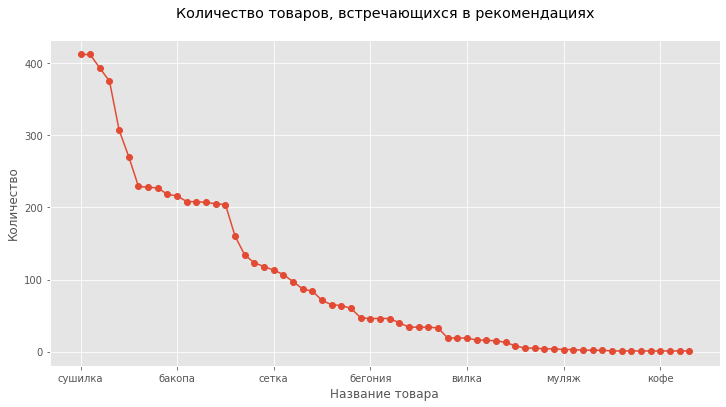

In [124]:
rec_items_clients['items'].value_counts().plot(style='o-')
plt.xlabel('Название товара')
plt.ylabel('Количество')
plt.title('Количество товаров, встречающихся в рекомендациях'+'\n');

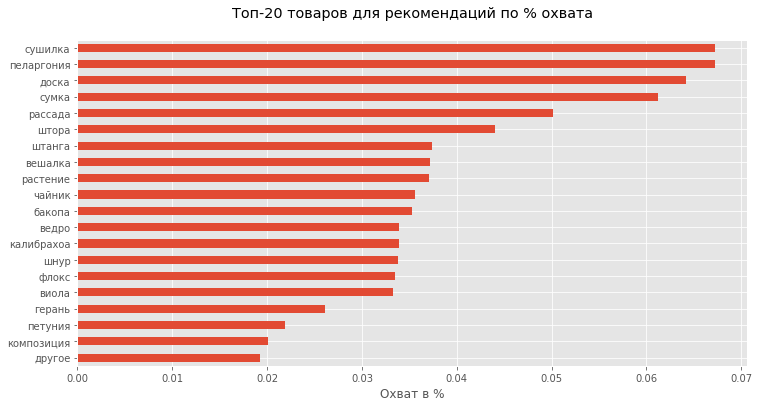

In [125]:
rec_items_clients['items'].value_counts(normalize=True).head(20).sort_values().plot(kind='barh')

plt.xlabel('Охват в %')
plt.title('Топ-20 товаров для рекомендаций по % охвата'+'\n');

In [126]:
print('Охват Топ-5 самых популярных товаров в рекомендациях: {:.2%}'.format(rec_items_clients['items'].value_counts(normalize=True).head().sum()))

Охват Топ-5 самых популярных товаров в рекомендациях: 31.00%


In [127]:
print('Всего уникальных товаров для рекомендаций:', rec_items_clients['items'].nunique())
print('Доля товаров, участвующих в рекомендациях: {:.2%}'.format( 
     rec_items_clients['items'].nunique() /\
     df[df['is_regular_customer'] == 0]['category'].nunique()))

Всего уникальных товаров для рекомендаций: 64
Доля товаров, участвующих в рекомендациях: 28.19%


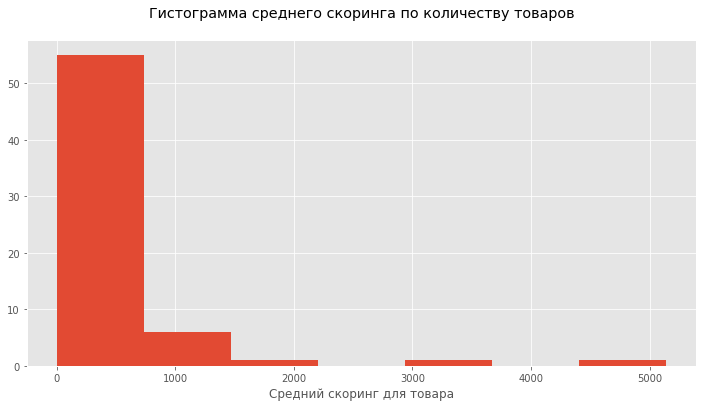

In [128]:
rec_items_clients.groupby('items')['scoring'].mean().hist(bins=7)

plt.xlabel('Средний скоринг для товара')
plt.title('Гистограмма среднего скоринга по количеству товаров'+'\n');

## По клиентам

In [129]:
print('Клиентов с рекомендациями:', rec_items_clients['customer_id'].nunique())
print('Доля клиентов получивших рекомендацию: {:.2%}'.format( 
     rec_items_clients['customer_id'].nunique() /\
     df[df['is_regular_customer'] == 0]['customer_id'].nunique()))

Клиентов с рекомендациями: 1463
Доля клиентов получивших рекомендацию: 68.81%


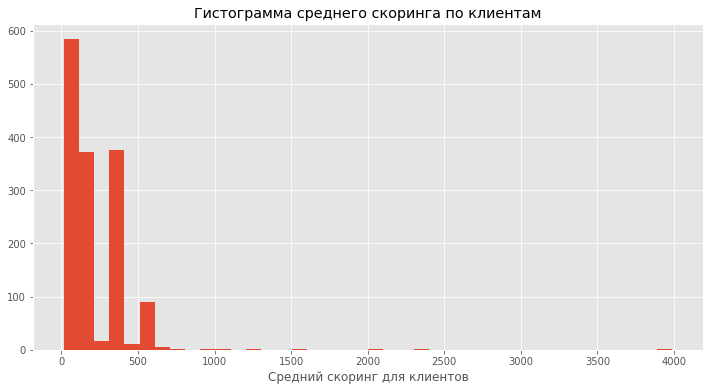

In [132]:
rec_items_clients.groupby('customer_id')['scoring'].mean().hist(bins=40)

plt.xlabel('Средний скоринг для клиентов')
plt.title('Гистограмма среднего скоринга по клиентам');

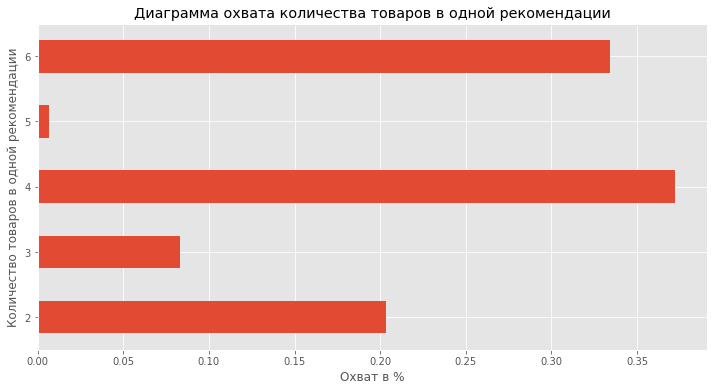

In [133]:
# как распределяется количество товаров на одного клиента

rec_items_clients['order_id'].value_counts().value_counts(normalize=True).sort_index().plot(kind='barh')

plt.xlabel('Охват в %')
plt.ylabel('Количество товаров в одной рекомендации')
plt.title('Диаграмма охвата количества товаров в одной рекомендации');

In [134]:
# проверяем на наличие повторяющихся товаров в одной рекомендации

temp = rec_items_clients.groupby('order_id')['items'].agg(['count', 'nunique'])
len(temp[temp['count'] != temp['nunique']])

0

# Заключение

**Итого**

На основе лога покупок в интернет магазине за определенный период были подготовлены товарные рекомендации для последующей Email рассылки. Формат результирующего файла определен сервисом Email рассылки - MindBox.

Для вычисления товаров для рекомендаций использовался следующий алгоритм:
1. Расчет вероятности заказа товара Y, если в первом заказе присутствует товар Х на основании заказов постоянных клиентов 
2. Расчет скоринга для каждого товара на основе произведения медианной стоимости и вероятности заказа
3. Подготовка товарных рекомендаций на основе состава корзины для клиентов, совершивших первый заказ


In [135]:
stop

NameError: name 'stop' is not defined

In [ ]:
rec_items_clients.to_csv('rec_items_clients_final.csv')